# Small Demo on RAG QA with Product Features of Apple iOS 17

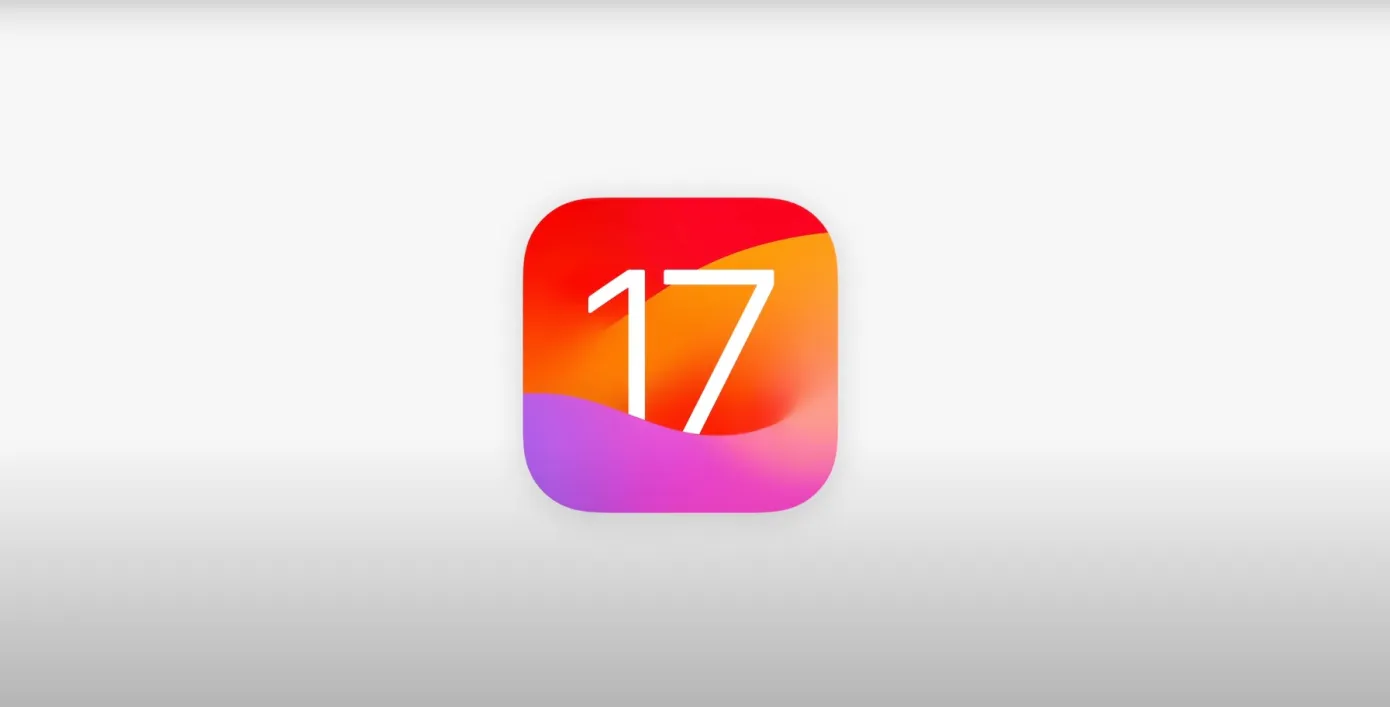


## Overview


Large Language Models (LLMs) have improved quantitatively and qualitatively. They can learn new abilities without being directly trained on them. However, there are constraints with LLMs - they are unaware of events after training and it is almost impossible to trace the sources to their responses. It is preferred for LLM based systems to cite their sources and be grounded in facts.

To solve for the constraints, one of the approaches is to augment the prompt sent to LLM with relevant data retrieved from an external knowledge base through Information Retrieval (IR) mechanism. This approach is called Retrieval Augmented Generation (RAG), also known as Generative QA in the context of the QA task. There are two main components in RAG based architecture: (1) Retriever and (2) Generator.

- **Retriever:** The knowledge base is integrated with an IR mechanism, also known as a Retriever, to retrieve relevant snippets from documents based on the user's query. The knowledge base can be your own document corpus, databases, or APIs. The Retriever can be implemented using term-based search (e.g. keyword, TF-IDF). Another approach is to use vector search based on dense embeddings, which captures semantically rich information in the text, leading to much more efficient information retrieval. The relevant snippets retrieved from the IR mechanism are passed as “context” to the next stage, Generator.
- **Generator:** The context - relevant  snippets from the knowledge base - are passed to an LLM to generate a well formed response grounded by the source documents.

This approach extracts relevant info from knowledge base to respond to queries, avoiding LLM memory limits and hallucinations. An added advantage is you can keep knowledge base up-to-date with new documents, ensuring grounded, accurate, relevant responses.

### High Level Flow

Following is the high level flow of implementation:

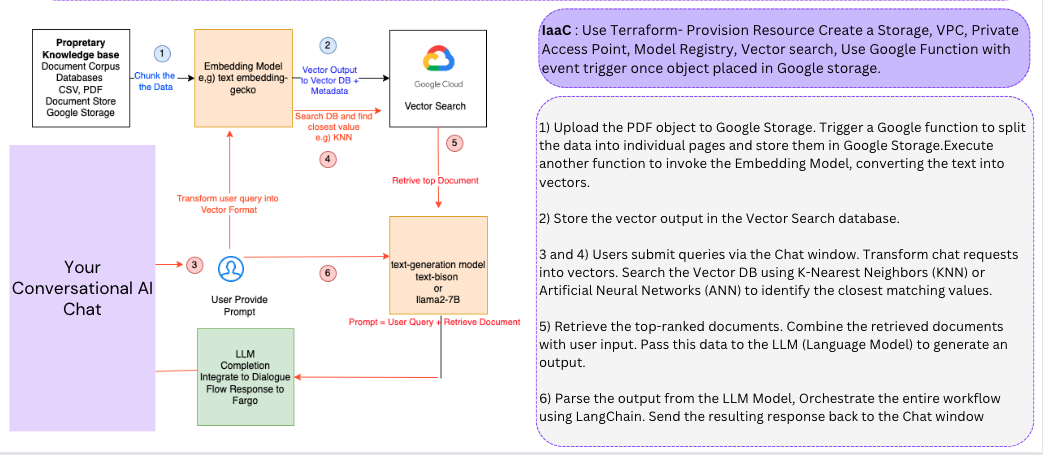

Following are the sequence of tasks when ingesting knowledge base sources into the vector store:
- Read the documents (PDF files in this notebook)
- Chunk the documents  to include relevant parts of the document as context to the prompt
- Generate embeddings for each chunked document
- Add embedding to the vector store

Following is the data flow at runtime when user prompts the model:
- User enters a prompt or asks a question as a prompt
- Generated embedding for the user prompt to capture semantics
- Search the vector store to retrieve the nearest embeddings (relevant documents) closer to the prompt
- Fetch the actual text for the retrieved embeddings to add as context to the user's prompt
- Add the retrieved documents as context to the user's prompt
- Send the updated prompt to the LLM
- Return a summarized response to the user with references to the sources from the knowledge base

### Objective

This notebooks demonstrates implementing a QA system based on retrieval augmented generation pattern that responds to questions based on a private collection of documents and adds references to the relevant documents. The datasets used as a private document corpus is a sample of Google published research papers.

You will learn how to:
- [x] Use LangChain RetrievalQA chain with built-in integration for Vertex AI PaLM API for [Text](https://python.langchain.com/en/latest/modules/models/llms/integrations/google_vertex_ai_palm.html), [Embeddings API](https://python.langchain.com/en/latest/modules/models/text_embedding/examples/google_vertex_ai_palm.html) and [Vertex AI - Vector Search](https://python.langchain.com/en/latest/modules/indexes/vectorstores/examples/matchingengine.html)
- [x] Extract text from PDF files stored on Cloud Storage bucket
- [x] Generate embeddings using Vertex AI Embedding API to generate embeddings to capture semantics
- [x] [Vertex AI - Vector Search](https://cloud.google.com/vertex-ai/docs/vector-search/overview) as a managed vector store on cloud to store the generated embeddings
- [x] Query Matching Engine index and return relevant results
- [x] Vertex AI PaLM API for Text as LLM to synthesize results and respond to the user query

**NOTE**: The notebook uses custom Matching Engine wrapper with LangChain to support streaming index updates and deploying index on public endpoint.



## Getting Started

### Install Vertex AI SDK, other packages and their dependencies

Install the following packages required to execute this notebook.

In [1]:
# Install Vertex AI LLM SDK
! pip install --user --upgrade google-cloud-aiplatform==1.31.0 langchain==0.0.201

# Dependencies required by Unstructured PDF loader
! sudo apt -y -qq install tesseract-ocr libtesseract-dev
! sudo apt-get -y -qq install poppler-utils
! pip install --user unstructured==0.7.5 pdf2image==1.16.3 pytesseract==0.3.10 pdfminer.six==20221105

# For Matching Engine integration dependencies (default embeddings)
! pip install --user tensorflow_hub==0.13.0 tensorflow_text==2.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


The following additional packages will be installed:
  libarchive-dev libleptonica-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev tesseract-ocr
  tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 18 not upgraded.
Need to get 8,560 kB of archives.
After this operation, 31.6 MB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 6.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 120875 files and directories

#### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [2]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ Before proceeding, please wait for the kernel to finish restarting ⚠️</b>
</div>

### Authenticating your notebook environment
If you are using Colab, you will need to authenticate yourself first. The next cell will check if you are currently using Colab, and will start the authentication process.

If you are using Vertex AI Workbench, you will not require additional authentication.

For more information, you can check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

### Download custom Python modules and utilities

The cell below will download some helper functions needed for using [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) in this notebook. These helper functions were created to keep this notebook more tidy and concise, and you can also [view them directly on Github](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/language/use-cases/document-qa/utils).

In [2]:
import os
import urllib.request

if not os.path.exists("utils"):
    os.makedirs("utils")

url_prefix = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/language/use-cases/document-qa/utils"
files = ["__init__.py", "matching_engine.py", "matching_engine_utils.py"]

for fname in files:
    urllib.request.urlretrieve(f"{url_prefix}/{fname}", filename=f"utils/{fname}")

### Import libraries

In [3]:
import json
import textwrap
# Utils
import time
import uuid
from typing import List

import numpy as np
import vertexai
# Vertex AI
from google.cloud import aiplatform

print(f"Vertex AI SDK version: {aiplatform.__version__}")

# Langchain
import langchain

print(f"LangChain version: {langchain.__version__}")

from langchain.chains import RetrievalQA
from langchain.document_loaders import GCSDirectoryLoader
from langchain.embeddings import VertexAIEmbeddings
from langchain.llms import VertexAI
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel

# Import custom Matching Engine packages
from utils.matching_engine import MatchingEngine
from utils.matching_engine_utils import MatchingEngineUtils

Vertex AI SDK version: 1.31.0
LangChain version: 0.0.201


In [4]:
PROJECT_ID = "conversationai-401012"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI SDK
vertexai.init(project=PROJECT_ID, location=REGION)

Next you will define some utility functions that you will use for the Vertex AI Embeddings API

In [5]:
# Utility functions for Embeddings API with rate limiting
def rate_limit(max_per_minute):
    period = 60 / max_per_minute
    print("Waiting")
    while True:
        before = time.time()
        yield
        after = time.time()
        elapsed = after - before
        sleep_time = max(0, period - elapsed)
        if sleep_time > 0:
            print(".", end="")
            time.sleep(sleep_time)


class CustomVertexAIEmbeddings(VertexAIEmbeddings, BaseModel):
    requests_per_minute: int
    num_instances_per_batch: int

    # Overriding embed_documents method
    def embed_documents(self, texts: List[str]):
        limiter = rate_limit(self.requests_per_minute)
        results = []
        docs = list(texts)

        while docs:
            # Working in batches because the API accepts maximum 5
            # documents per request to get embeddings
            head, docs = (
                docs[: self.num_instances_per_batch],
                docs[self.num_instances_per_batch :],
            )
            chunk = self.client.get_embeddings(head)
            results.extend(chunk)
            next(limiter)

        return [r.values for r in results]

### Initialize LangChain Models

You initialize LangChain Models with the pre-trained text, chat and embeddings generation model called `text-bison@001`, `chat-bison@001` and `textembedding-gecko@001` respectively.

In [6]:
# Text model instance integrated with langChain
llm = VertexAI(
    model_name="text-bison@001",
    max_output_tokens=1024,
    temperature=0.2,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

# Embeddings API integrated with langChain
EMBEDDING_QPM = 100
EMBEDDING_NUM_BATCH = 5
embeddings = CustomVertexAIEmbeddings(
    requests_per_minute=EMBEDDING_QPM,
    num_instances_per_batch=EMBEDDING_NUM_BATCH,
)

---

## STEP 1: Create Matching Engine Index and Endpoint for Retrieval


[Embeddings](https://cloud.google.com/blog/topics/developers-practitioners/meet-ais-multitool-vector-embeddings) are a way of representing data as n-dimensional vector, in a space where the locations of those points in space are semantically meaningful. These embeddings can be then used to find similar data points. You can get text embeddings using [Vertex AI Embeddings API](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings). These embeddings are managed using a vector database.


[Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) is a Google Cloud managed vector database, which stores data as high-dimensional vectors (embeddings) and can find the most similar vectors from over a billion vectors. Matching Engine's Approximate Nearest Neigbors (ANN) service can serve similarity-matching queries at high queries per second (QPS). Unlike vector stores that run locally, Matching Engine is optimized for scale (multi-million and billion vectors) and it's an enterprise ready engine.

As part of the environment setup, create an index on Vertex AI Matching Engine and deploy the index to an Endpoint. Index Endpoint can be [public](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-public) or [private](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-vpc). This notebook uses a **Public endpoint**.

<br/>

Refer to the [Matching Engine documentation](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) for details.

<br/>

<div class="alert alert-block alert-warning">
<b>⚠️ NOTE: Please note creating an Index on Matching Engine and deploying the Index to an Index Endpoint can take up to 1 hour.</b>
</div>

- Configure parameters to create Matching Engine index
    - `ME_REGION`: Region where Matching Engine Index and Index Endpoint are deployed
    - `ME_INDEX_NAME`: Matching Engine index display name
    - `ME_EMBEDDING_DIR`: Cloud Storage path to allow inserting, updating or deleting the contents of the Index
    - `ME_DIMENSIONS`: The number of dimensions of the input vectors. Vertex AI Embedding API generates 768 dimensional vector embeddings.

In [7]:
ME_REGION = "us-central1"
ME_INDEX_NAME = f"{PROJECT_ID}-me-index"  # @param {type:"string"}
ME_EMBEDDING_DIR = f"{PROJECT_ID}-me-bucket"  # @param {type:"string"}
ME_DIMENSIONS = 768  # when using Vertex PaLM Embedding

Make a Google Cloud Storage bucket for your Matching Engine index

In [9]:
! set -x && gsutil mb -p $PROJECT_ID -l us-central1 gs://$ME_EMBEDDING_DIR

+ gsutil mb -p conversationai-401012 -l us-central1 gs://conversationai-401012-me-bucket
Creating gs://conversationai-401012-me-bucket/...
ServiceException: 409 A Cloud Storage bucket named 'conversationai-401012-me-bucket' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


- Create a dummy embeddings file to initialize when creating the index

In [10]:
# dummy embedding
init_embedding = {"id": str(uuid.uuid4()), "embedding": list(np.zeros(ME_DIMENSIONS))}

# dump embedding to a local file
with open("embeddings_0.json", "w") as f:
    json.dump(init_embedding, f)

# write embedding to Cloud Storage
! set -x && gsutil cp embeddings_0.json gs://{ME_EMBEDDING_DIR}/init_index/embeddings_0.json

+ gsutil cp embeddings_0.json gs://conversationai-401012-me-bucket/init_index/embeddings_0.json
Copying file://embeddings_0.json [Content-Type=application/json]...
/ [1 files][  3.8 KiB/  3.8 KiB]                                                
Operation completed over 1 objects/3.8 KiB.                                      


### Create Index

You can [create index](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index#create-index) on Vertex AI - Vector search for batch updates or streaming updates.

This notebook creates Vector search  Index:
- With [streaming updates](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index#create-stream)
- With default configuration - e.g. small shard size

You can [update the index configuration](https://cloud.google.com/vertex-ai/docs/matching-engine/configuring-indexes) in the Vector search  utilities script.

<br/>

While the index is being created and deployed, you can read more about Matching Engine's ANN service which uses a new type of vector quantization developed by Google Research: [Accelerating Large-Scale Inference with Anisotropic Vector Quantization](https://arxiv.org/abs/1908.10396).

For more information about how this works, see [Announcing ScaNN: Efficient
Vector Similarity Search](https://ai.googleblog.com/2020/07/announcing-scann-efficient-vector.html).

In [11]:
mengine = MatchingEngineUtils(PROJECT_ID, ME_REGION, ME_INDEX_NAME)

In [12]:
index = mengine.create_index(
    embedding_gcs_uri=f"gs://{ME_EMBEDDING_DIR}/init_index",
    dimensions=ME_DIMENSIONS,
    index_update_method="streaming",
    index_algorithm="tree-ah",
)
if index:
    print(index.name)

...................................................projects/880171706777/locations/us-central1/indexes/3340536227509043200


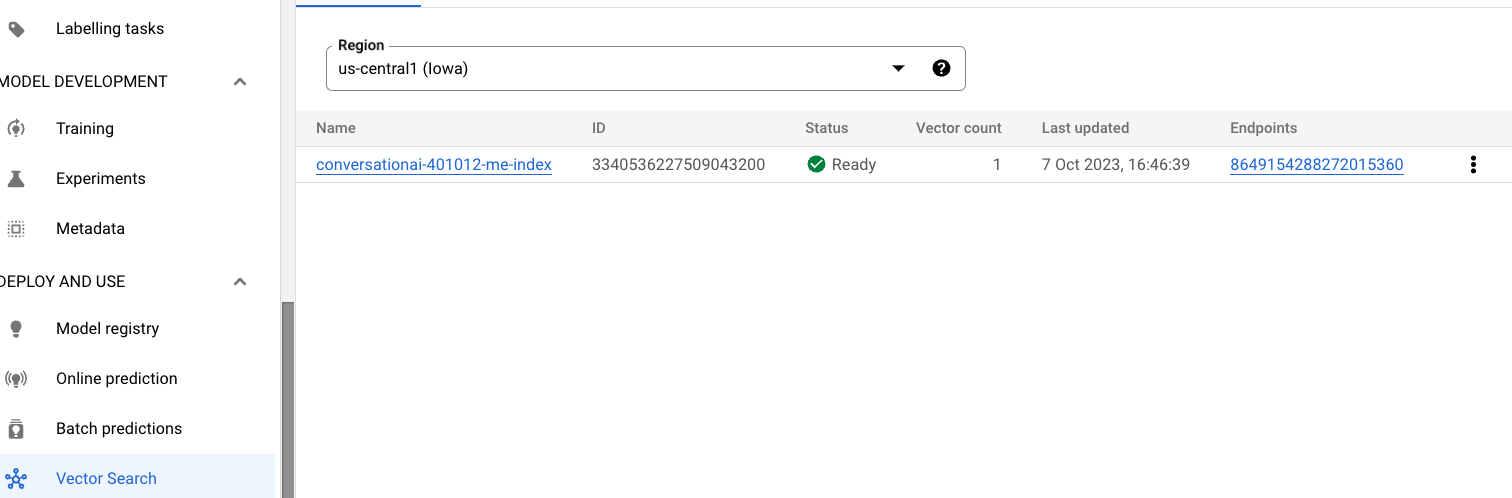

### Deploy Index to Endpoint

Deploy index to Index Endpoint on Matching Engine. This notebook [deploys the index to a public endpoint](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-public). The deployment operation creates a  public endpoint that will be used for querying the index for approximate nearest neighbors.

For deploying index to a Private Endpoint, refer to the [documentation](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-vpc) to set up pre-requisites.

In [13]:
index_endpoint = mengine.deploy_index()
if index_endpoint:
    print(f"Index endpoint resource name: {index_endpoint.name}")
    print(
        f"Index endpoint public domain name: {index_endpoint.public_endpoint_domain_name}"
    )
    print("Deployed indexes on the index endpoint:")
    for d in index_endpoint.deployed_indexes:
        print(f"    {d.id}")

.................Index endpoint resource name: projects/880171706777/locations/us-central1/indexEndpoints/8649154288272015360
Index endpoint public domain name: 
Deployed indexes on the index endpoint:


---

## STEP 2: Add Document Embeddings to Matching Engine - Vector Store

This step ingests and parse PDF documents, split them, generate embeddings and add the embeddings to the vector store. The document corpus used as dataset is a sample of Google published research papers across different domains - large models, traffic simulation, productivity etc.

### Ingest PDF files

The document corpus is hosted on Cloud Storage bucket (at `gs://github-repo/documents/google-research-pdfs/`) and LangChain provides a convenient document loader [`GCSDirectoryLoader`](https://python.langchain.com/en/latest/modules/indexes/document_loaders/examples/google_cloud_storage_directory.html) to load documents from a Cloud Storage bucket. The loader uses `Unstructured` package to load files of many types including pdfs, images, html and more.

Make a Google Cloud Storage bucket in your GCP project to copy the document files into.

In [14]:
GCS_BUCKET_DOCS = f"{PROJECT_ID}-documents"
! set -x && gsutil mb -p $PROJECT_ID -l us-central1 gs://$GCS_BUCKET_DOCS

+ gsutil mb -p conversationai-401012 -l us-central1 gs://conversationai-401012-documents
Creating gs://conversationai-401012-documents/...


Copy document files to your bucket

In [19]:
folder_prefix = "documents/ios-feature-pdfs/"
! wget https://www.apple.com/ios/ios-17/pdf/iOS_All_New_Features.pdf
! gsutil cp -r iOS_All_New_Features.pdf gs://$GCS_BUCKET_DOCS/$folder_prefix

--2023-10-07 11:40:49--  https://www.apple.com/ios/ios-17/pdf/iOS_All_New_Features.pdf
Resolving www.apple.com (www.apple.com)... 23.38.76.198, 2600:1407:3c00:a85::1aca, 2600:1407:3c00:a87::1aca
Connecting to www.apple.com (www.apple.com)|23.38.76.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367666 (359K) [application/pdf]
Saving to: ‘iOS_All_New_Features.pdf.1’

iOS_All_New_Feature 100%[===================>] 359.05K  --.-KB/s    in 0.06s   

2023-10-07 11:40:49 (6.25 MB/s) - ‘iOS_All_New_Features.pdf.1’ saved [367666/367666]

Copying file://iOS_All_New_Features.pdf [Content-Type=application/pdf]...
/ [1 files][359.0 KiB/359.0 KiB]                                                
Operation completed over 1 objects/359.0 KiB.                                    


Load documents and add document metadata such as file name, to be retrieved later when citing the references.

In [20]:
# Ingest PDF files

print(f"Processing documents from {GCS_BUCKET_DOCS}")
loader = GCSDirectoryLoader(
    project_name=PROJECT_ID, bucket=GCS_BUCKET_DOCS, prefix=folder_prefix
)
documents = loader.load()

# Add document name and source to the metadata
for document in documents:
    doc_md = document.metadata
    document_name = doc_md["source"].split("/")[-1]
    # derive doc source from Document loader
    doc_source_prefix = "/".join(GCS_BUCKET_DOCS.split("/")[:3])
    doc_source_suffix = "/".join(doc_md["source"].split("/")[4:-1])
    source = f"{doc_source_prefix}/{doc_source_suffix}"
    document.metadata = {"source": source, "document_name": document_name}

print(f"# of documents loaded (pre-chunking) = {len(documents)}")

Processing documents from conversationai-401012-documents


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# of documents loaded (pre-chunking) = 1


Verify document metadata

In [21]:
documents[0].metadata

{'source': 'conversationai-401012-documents/ios-feature-pdfs',
 'document_name': 'iOS_All_New_Features.pdf'}

### Chunk documents

Split the documents to smaller chunks. When splitting the document, ensure a few chunks can fit within the context length of LLM.

In [22]:
# split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=50,
    separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],
)
doc_splits = text_splitter.split_documents(documents)

# Add chunk number to metadata
for idx, split in enumerate(doc_splits):
    split.metadata["chunk"] = idx

print(f"# of documents = {len(doc_splits)}")

# of documents = 62


In [23]:
doc_splits[0].metadata

{'source': 'conversationai-401012-documents/ios-feature-pdfs',
 'document_name': 'iOS_All_New_Features.pdf',
 'chunk': 0}

### Configure Matching Engine as Vector Store

Get Matching Engine Index id and Endpoint id

In [24]:
ME_INDEX_ID, ME_INDEX_ENDPOINT_ID = mengine.get_index_and_endpoint()
print(f"ME_INDEX_ID={ME_INDEX_ID}")
print(f"ME_INDEX_ENDPOINT_ID={ME_INDEX_ENDPOINT_ID}")

ME_INDEX_ID=projects/880171706777/locations/us-central1/indexes/3340536227509043200
ME_INDEX_ENDPOINT_ID=projects/880171706777/locations/us-central1/indexEndpoints/8649154288272015360


Initialize Matching Engine vector store with text embeddings model

In [25]:
# initialize vector store
me = MatchingEngine.from_components(
    project_id=PROJECT_ID,
    region=ME_REGION,
    gcs_bucket_name=f"gs://{ME_EMBEDDING_DIR}".split("/")[2],
    embedding=embeddings,
    index_id=ME_INDEX_ID,
    endpoint_id=ME_INDEX_ENDPOINT_ID,
)

### Add documents as embeddings in Matching Engine as index

The document chunks are transformed as embeddings (vectors) using Vertex AI Embeddings API and added to the index with **[streaming index update](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index#create-index)**. With Streaming Updates, you can update and query your index within a few seconds.

The original document text is stored on Cloud Storage bucket had referenced by id.

Prepare text and metadata to be added to the vectors

In [26]:
# Store docs as embeddings in Matching Engine index
# It may take a while since API is rate limited
texts = [doc.page_content for doc in doc_splits]
metadatas = [
    [
        {"namespace": "source", "allow_list": [doc.metadata["source"]]},
        {"namespace": "document_name", "allow_list": [doc.metadata["document_name"]]},
        {"namespace": "chunk", "allow_list": [str(doc.metadata["chunk"])]},
    ]
    for doc in doc_splits
]

Add embeddings to the vector store

**NOTE:** Depending on the volume and size of documents, this step may take time.

In [27]:
doc_ids = me.add_texts(texts=texts, metadatas=metadatas)

Waiting
............

Validate semantic search with Matching Engine is working

In [28]:
# Test whether search from vector store is working
me.similarity_search("What is Improved Autocorrect accuracy.", k=2)

Waiting


[Document(page_content='Enhanced sentence corrections.5 Autocorrection of sentences can correct more types of grammatical mistakes. The keyboard also underlines corrections and suggestions, so they are easier to see and change if needed.\n\nNew keyboard layouts. New keyboard layouts are available for Akan, Chuvash, Hausa, Hmong (Pahawh), Ingush, Kabyle, Liangshan Yi, Mandaic, Mi’kmaw, N’Ko, Osage, Rejang, Tamazight (Standard Moroccan), Wancho, Wolastoqey, and Yoruba.\n\nNotifications. Get a notification when new suggestions to journal about are available.\n\nJournaling schedule. Set a schedule for the start or end of your day to help make journaling a consistent practice.\n\nImproved predictions. Predictive text provides even better word predictions by leveraging a new transformer model in Chinese (Simplified), English, French, and Spanish keyboards.6 Additionally, enhanced on-device language models improve predictions across even more languages.8', metadata={'source': 'conversationai-

[Document(page_content='Enhanced sentence corrections.5 Autocorrection of sentences can correct more types of grammatical mistakes. The keyboard also underlines corrections and suggestions, so they are easier to see and change if needed.\n\nNew keyboard layouts. New keyboard layouts are available for Akan, Chuvash, Hausa, Hmong (Pahawh), Ingush, Kabyle, Liangshan Yi, Mandaic, Mi’kmaw, N’Ko, Osage, Rejang, Tamazight (Standard Moroccan), Wancho, Wolastoqey, and Yoruba.\n\nNotifications. Get a notification when new suggestions to journal about are available.\n\nJournaling schedule. Set a schedule for the start or end of your day to help make journaling a consistent practice.\n\nImproved predictions. Predictive text provides even better word predictions by leveraging a new transformer model in Chinese (Simplified), English, French, and Spanish keyboards.6 Additionally, enhanced on-device language models improve predictions across even more languages.8', metadata={'source': 'conversationai-401012-documents/ios-feature-pdfs', 'document_name': 'iOS_All_New_Features.pdf', 'chunk': '15', 'score': 0.7438047528266907}),
 Document(page_content='One-time verification code. One-time verification codes that are sent to your email will now autofill in the password field so you no longer need to search in your Mail messages, and they are automatically deleted after you use them.\n\nImproved handwriting recognition. Live Text recognizes handwritten text even better.\n\nEasier automation. App Shortcuts can be added alongside other system features with a new automation setup flow. Additional triggers are now supported for Wallet, external displays, and Stage Manager.\n\nEdit hyperlink text. Edit a URL link in your Mail messages so you can format messages more neatly.\n\nLock Screen\n\nMotion effect for Live Photo wallpaper. An all- new motion effect for Live Photos makes your Lock Screen feel more dynamic than ever on wake, and settles into your Home Screen when unlocked.', metadata={'source': 'conversationai-401012-documents/ios-feature-pdfs', 'document_name': 'iOS_All_New_Features.pdf', 'chunk': '47', 'score': 0.6870058178901672})]

---

## STEP 3: Retrieval based Question/Answering Chain

LangChain provides easy ways to chain multiple tasks that can do QA over a set of documents, called QA chains. The notebook works with [**RetrievalQA**](https://python.langchain.com/en/latest/modules/chains/index_examples/vector_db_qa.html) chain which is based on **load_qa_chain** under the hood.

In the retrieval augmented generation chain, the Matching Engine uses semantic search to retrieve relevant documents based on the user's question. The resulting documents are then added as additional context to the prompt sent to the LLM, along with the user's question, to generate a response. Thus the response generated by LLM is grounded to your documents in the corpus.

This way, a user would only need to provide their question as a prompt and the retrieval chain would be able to seek the answers using Matching Engine directly, and return a proper text response answering the question.

### Configure Question/Answering Chain with Vector Store using Text

Define Matching Engine Vector Store as retriever that takes in a query and returns a list of relevant documents. The retriever implementation supports configuring number of documents to fetch and filtering by search distance as a threshold value parameter.

In [30]:
# Create chain to answer questions
NUMBER_OF_RESULTS = 10
SEARCH_DISTANCE_THRESHOLD = 0.6

# Expose index to the retriever
retriever = me.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": NUMBER_OF_RESULTS,
        "search_distance": SEARCH_DISTANCE_THRESHOLD,
    },
)

Customize the default retrieval prompt template

In [31]:
template = """SYSTEM: You are an intelligent assistant helping the users with their questions on new Product.

Question: {question}

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

=============
{context}
=============

Question: {question}
Helpful Answer:"""

Configure RetrievalQA chain

In [32]:
# Uses LLM to synthesize results from the search index.
# Use Vertex PaLM Text API for LLM
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template,
            input_variables=["context", "question"],
        ),
    },
)

Enable verbose logging for debugging and troubleshooting the chains which includes the complete prompt to the LLM

In [33]:
# Enable for troubleshooting
qa.combine_documents_chain.verbose = True
qa.combine_documents_chain.llm_chain.verbose = True
qa.combine_documents_chain.llm_chain.llm.verbose = True

Utility function to format the result

In [34]:
def formatter(result):
    print(f"Query: {result['query']}")
    print("." * 80)
    if "source_documents" in result.keys():
        for idx, ref in enumerate(result["source_documents"]):
            print("-" * 80)
            print(f"REFERENCE #{idx}")
            print("-" * 80)
            if "score" in ref.metadata:
                print(f"Matching Score: {ref.metadata['score']}")
            if "source" in ref.metadata:
                print(f"Document Source: {ref.metadata['source']}")
            if "document_name" in ref.metadata:
                print(f"Document Name: {ref.metadata['document_name']}")
            print("." * 80)
            print(f"Content: \n{wrap(ref.page_content)}")
    print("." * 80)
    print(f"Response: {wrap(result['result'])}")
    print("." * 80)


def wrap(s):
    return "\n".join(textwrap.wrap(s, width=120, break_long_words=False))


def ask(query, qa=qa, k=NUMBER_OF_RESULTS, search_distance=SEARCH_DISTANCE_THRESHOLD):
    qa.retriever.search_kwargs["search_distance"] = search_distance
    qa.retriever.search_kwargs["k"] = k
    result = qa({"query": query})
    return formatter(result)

### Run QA chain on sample questions

Following are sample questions you could try. Wehn you run the query, RetrievalQA chain takes the user question, call the retriever to fetch top *k* semantically similar texts from the Matching Engine Index (vector store) and passes to the LLM as part of the prompt. The final prompt sent to the LLM looks of this format:

```
SYSTEM: {system}

=============
{context}
=============

Question: {question}
Helpful Answer:
```

where:
 - `system`: Instructions for LLM on how to respond to the question based on the context
 - `context`: Semantically similar text (a.k.a snippets) retreived from the vector store
 - `question`: question posed by the user


The response returned from the LLM includes both the response and references that lead to the response. This way the response from LLM is always grounded to the sources. Here we have formatted the response as:

```
Question: {question}
--------------------------------------------------------------------------------
REFERENCE #n
--------------------------------------------------------------------------------
Matching Score: <score>
Document Source: <document source location>
Document Name: <document file name>
................................................................................
Context:
{}
................................................................................
Response: <answer returned by the LLM>
................................................................................
```

In [35]:
ask("Tell me about Explicit language handling.")



> Entering new  chain...
Waiting


> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on new Product.

Question: Tell me about Explicit language handling.

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

App privacy improvements. App developers can provide even more accurate Privacy Nutrition Labels using new tools that provide better transparency into the data practices of their partners.

Live Speech. Type what you want to say and have it spoken out loud in phone calls, FaceTime calls, or for in-person conversations.

Virtual game controller with Switch Control. Turn your favorit

In [36]:
ask("Tell me about Photos privacy prompt improvements.")



> Entering new  chain...
Waiting


> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on new Product.

Question: Tell me about Photos privacy prompt improvements.

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

Mental health education and resources. Read articles to help you understand and improve your mental health and wellbeing, and access localized resources.

Privacy and Security

Photos privacy prompt improvements. An embedded photo picker for apps lets you pick photos to share within the app’s experience, without sharing your entire library. When an app does ask to access yo

Let's ask a question which is outside of the domain in the corpus. You should see something like - "I cannot determine the answer to that". This is because the output is conditioned in the prompts to not to respond when the question is out of the context.

Following is the instructions in prompt template that is configured in the retrieval QA chain above:

```
Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."
```

In [37]:
ask("Where is 2023 Cricket world cup happening")



> Entering new  chain...
Waiting


> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on new Product.

Question: Where is 2023 Cricket world cup happening

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

© 2023 Apple Inc. All rights reserved. Apple, the Apple logo, AirDrop, AirPlay, AirPods, AirPods Max, AirPods Pro, AirTag, Animoji, Apple Card, Apple Cash, Apple Music, Apple Pay, Apple TV, Apple Wallet, Apple Watch, Apple Watch SE, CarPlay, Digital Crown, Face ID, FaceTime, Find My, iMessage, iPad, iPhone, Live Photos, Live Text, Mac, MagSafe, Memoji, Pages, QuickPath, Safari, Sir

---